- This DL model implementation uses the Tensorflow's Functional API
- The output is very long, scroll down to the bottom to see the result as well as the corresponding model and parameters.
- The model is optimized for <b>precision</b>. We can re-run it for accuracy by changing the metrics and the parameter <b>monitor</b> in the ModelCheckpoint.

In [1]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Precision
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
import pandas as pd
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")



In [2]:

#this block is for reproducible results
np.random.seed(0)
tf.random.set_seed(0)

gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], False)

try:
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass


In [3]:
random_state = 0 # this variable is used for sklearn classifiers

# load dataframe
train = pd.read_csv('weatherAUS.csv')
#train=train.sort_values(by='Date')
train=train.set_index('Date')

train = train.sample(frac=1).reset_index(drop=True)

#remove the entries without label
train = train[~train['RainTomorrow'].isna()]

#NA
train =train.dropna()

#convert Location, WindGustDir,WindDir9am to categorical features
le =LabelEncoder()
le.fit(train['Location'])
train['Location']=le.transform(train['Location'])
le.fit(train['WindGustDir'])
train['WindGustDir'] = le.transform(train['WindGustDir'])
le.fit(train['WindDir9am']) 
train['WindDir9am'] = le.transform(train['WindDir9am'])
le.fit(train['WindDir3pm']) 
train['WindDir3pm'] = le.transform(train['WindDir3pm'])

#convert the text labels to categorical
train['RainToday']=train['RainToday'].map(dict(Yes=1, No=0))
train['RainTomorrow']=train['RainTomorrow'].map(dict(Yes=1, No=0))
X = train.drop('RainTomorrow',axis=1)
y = train['RainTomorrow']

# train / test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = random_state)

#normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# the deep learning model using TensorFlow's Functional API 
def keras_wrapper( optimizer):
    input = Input(shape=(21,), name="Rainfall Input")
    x = Dense(60, activation='relu', name="Dense-1")(input)
    x1 = Dense(40, activation='relu', name="Dense-2")(x)
    x = BatchNormalization(name="BN-1")(x1) # x1 here is intentioal, may be use for "shortcut" connections later                                            
    x = Dense(60, activation='relu', name="Dense-3")(x)
    x = Dropout(0.5, name="Dropout-1")(x)
    x = Dense(30, activation='relu',name="Dense-4")(x)
    x = BatchNormalization(name="BN-2")(x)
    x = Dense(20, activation='relu',name="Dense-5")(x)
    x = Dropout(0.5, name="Dropout-2")(x)
    x = Dense(40, activation='relu', name="Dense-6")(x)
    #x = x + x1                              # here is an example of shortcut connection
    x = BatchNormalization(name="BN-3")(x)
    x = Dense(40, activation='relu', name="Dense-7")(x)
    x = Dropout(0.5, name="Dropout-3")(x)
    output = Dense(1, activation='sigmoid', name="Output")(x)
    model = Model(inputs=input, outputs=output)
    model.compile( loss = "binary_crossentropy", optimizer="adam", metrics=['Precision']) 
    return model


In [4]:
def model_train_evaluation(optimizer, early_stopping_callback, lr_scheduler):
    clf = keras_wrapper( optimizer = optimizer)
    checkpoint = ModelCheckpoint(save_best_only=True, verbose=1, filepath='model.weights.best.hdf5', monitor='precision', mode='max')
    history = clf.fit(X_train, y_train,batch_size=512, 
                  callbacks=[checkpoint,lr_callback, early_stopping_callback],
                  epochs=400,
                  validation_data=(X_val, y_val), verbose = 1, shuffle = True )

    clf.load_weights('model.weights.best.hdf5')
    y_pred = clf.predict(X_test)
    y_1 = y_pred > 0.5
    y_1 = y_1.astype(int)
    precision = precision_score(y_test, y_1)
    accuracy = accuracy_score(y_test, y_1)
    return clf, history, precision, accuracy
    
    
optimizer = "adam"

# early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="precision",
    min_delta=0,
    patience=60,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=False,
    )
# learning rate decay
lr_scheduler = ExponentialDecay(
        initial_learning_rate=1e-3,
        staircase=False,
        decay_steps=5000,
        decay_rate=0.9
        #decay_rate = decay_rate[i]
        )
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

model, history, precision, accuracy= model_train_evaluation(optimizer, early_stopping_callback, lr_scheduler)

print("=======")
print(f"Precision: {precision}, accuracy: {accuracy},  lr: {lr_scheduler.get_config()}")

Epoch 1/400
83/83 [==============================] - 1s 7ms/step - loss: 0.7228 - precision: 0.2486 - val_loss: 0.5391 - val_precision: 0.0000e+00

Epoch 00001: precision improved from -inf to 0.29194, saving model to model.weights.best.hdf5
Epoch 2/400
83/83 [==============================] - 0s 4ms/step - loss: 0.4703 - precision: 0.5460 - val_loss: 0.4341 - val_precision: 1.0000

Epoch 00002: precision improved from 0.29194 to 0.57623, saving model to model.weights.best.hdf5
Epoch 3/400
83/83 [==============================] - 0s 4ms/step - loss: 0.4135 - precision: 0.6368 - val_loss: 0.3969 - val_precision: 0.9688

Epoch 00003: precision improved from 0.57623 to 0.64264, saving model to model.weights.best.hdf5
Epoch 4/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3916 - precision: 0.6588 - val_loss: 0.3865 - val_precision: 0.9715

Epoch 00004: precision improved from 0.64264 to 0.67217, saving model to model.weights.best.hdf5
Epoch 5/400
83/83 [================

83/83 [==============================] - 0s 4ms/step - loss: 0.3339 - precision: 0.7400 - val_loss: 0.3404 - val_precision: 0.9088

Epoch 00039: precision did not improve from 0.75815
Epoch 40/400
83/83 [==============================] - 0s 3ms/step - loss: 0.3322 - precision: 0.7444 - val_loss: 0.3487 - val_precision: 0.9250

Epoch 00040: precision did not improve from 0.75815
Epoch 41/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3251 - precision: 0.7467 - val_loss: 0.3590 - val_precision: 0.9364

Epoch 00041: precision did not improve from 0.75815
Epoch 42/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3333 - precision: 0.7512 - val_loss: 0.3418 - val_precision: 0.8947

Epoch 00042: precision did not improve from 0.75815
Epoch 43/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3246 - precision: 0.7602 - val_loss: 0.3474 - val_precision: 0.9012

Epoch 00043: precision did not improve from 0.75815
Epoch 44/400
83/83 [========

83/83 [==============================] - 0s 3ms/step - loss: 0.3163 - precision: 0.7530 - val_loss: 0.3677 - val_precision: 0.9664

Epoch 00080: precision did not improve from 0.75827
Epoch 81/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3199 - precision: 0.7465 - val_loss: 0.3539 - val_precision: 0.9457

Epoch 00081: precision did not improve from 0.75827
Epoch 82/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3207 - precision: 0.7550 - val_loss: 0.3662 - val_precision: 0.9651

Epoch 00082: precision did not improve from 0.75827
Epoch 83/400
83/83 [==============================] - 0s 3ms/step - loss: 0.3176 - precision: 0.7481 - val_loss: 0.3470 - val_precision: 0.9306

Epoch 00083: precision did not improve from 0.75827
Epoch 84/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3155 - precision: 0.7546 - val_loss: 0.3482 - val_precision: 0.9157

Epoch 00084: precision did not improve from 0.75827
Epoch 85/400
83/83 [========

83/83 [==============================] - 0s 4ms/step - loss: 0.3078 - precision: 0.7675 - val_loss: 0.3508 - val_precision: 0.9424

Epoch 00121: precision improved from 0.76213 to 0.76245, saving model to model.weights.best.hdf5
Epoch 122/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3144 - precision: 0.7528 - val_loss: 0.3600 - val_precision: 0.9444

Epoch 00122: precision did not improve from 0.76245
Epoch 123/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3060 - precision: 0.7577 - val_loss: 0.3645 - val_precision: 0.9605

Epoch 00123: precision did not improve from 0.76245
Epoch 124/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3164 - precision: 0.7532 - val_loss: 0.3558 - val_precision: 0.9525

Epoch 00124: precision did not improve from 0.76245
Epoch 125/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3134 - precision: 0.7453 - val_loss: 0.3503 - val_precision: 0.9361

Epoch 00125: precision did not 


Epoch 00161: precision did not improve from 0.76370
Epoch 162/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3093 - precision: 0.7637 - val_loss: 0.3554 - val_precision: 0.9483

Epoch 00162: precision improved from 0.76370 to 0.76411, saving model to model.weights.best.hdf5
Epoch 163/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3020 - precision: 0.7567 - val_loss: 0.3652 - val_precision: 0.9607

Epoch 00163: precision did not improve from 0.76411
Epoch 164/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3053 - precision: 0.7509 - val_loss: 0.3557 - val_precision: 0.9468

Epoch 00164: precision did not improve from 0.76411
Epoch 165/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3081 - precision: 0.7732 - val_loss: 0.3608 - val_precision: 0.9507

Epoch 00165: precision did not improve from 0.76411
Epoch 166/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3068 - precision: 0.7642 - val_lo

83/83 [==============================] - 0s 4ms/step - loss: 0.3004 - precision: 0.7734 - val_loss: 0.3564 - val_precision: 0.9388

Epoch 00202: precision improved from 0.76555 to 0.76696, saving model to model.weights.best.hdf5
Epoch 203/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3019 - precision: 0.7637 - val_loss: 0.3577 - val_precision: 0.9423

Epoch 00203: precision did not improve from 0.76696
Epoch 204/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3043 - precision: 0.7680 - val_loss: 0.3514 - val_precision: 0.9269

Epoch 00204: precision did not improve from 0.76696
Epoch 205/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3073 - precision: 0.7577 - val_loss: 0.3554 - val_precision: 0.9506

Epoch 00205: precision did not improve from 0.76696
Epoch 206/400
83/83 [==============================] - 0s 3ms/step - loss: 0.3038 - precision: 0.7625 - val_loss: 0.3601 - val_precision: 0.9323

Epoch 00206: precision did not 

83/83 [==============================] - 0s 3ms/step - loss: 0.3022 - precision: 0.7469 - val_loss: 0.3443 - val_precision: 0.9018

Epoch 00243: precision did not improve from 0.76783
Epoch 244/400
83/83 [==============================] - 0s 4ms/step - loss: 0.2981 - precision: 0.7574 - val_loss: 0.3547 - val_precision: 0.9397

Epoch 00244: precision did not improve from 0.76783
Epoch 245/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3032 - precision: 0.7646 - val_loss: 0.3566 - val_precision: 0.9255

Epoch 00245: precision did not improve from 0.76783
Epoch 246/400
83/83 [==============================] - 0s 4ms/step - loss: 0.2981 - precision: 0.7636 - val_loss: 0.3677 - val_precision: 0.9528

Epoch 00246: precision did not improve from 0.76783
Epoch 247/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3001 - precision: 0.7693 - val_loss: 0.3636 - val_precision: 0.9483

Epoch 00247: precision did not improve from 0.76783
Epoch 248/400
83/83 [===

83/83 [==============================] - 0s 4ms/step - loss: 0.2963 - precision: 0.7601 - val_loss: 0.3690 - val_precision: 0.9424

Epoch 00284: precision did not improve from 0.76920
Epoch 285/400
83/83 [==============================] - 0s 4ms/step - loss: 0.3014 - precision: 0.7587 - val_loss: 0.3647 - val_precision: 0.9420

Epoch 00285: precision did not improve from 0.76920
Epoch 286/400
83/83 [==============================] - 0s 4ms/step - loss: 0.2979 - precision: 0.7507 - val_loss: 0.3525 - val_precision: 0.9270

Epoch 00286: precision did not improve from 0.76920
Epoch 287/400
83/83 [==============================] - 0s 4ms/step - loss: 0.2959 - precision: 0.7681 - val_loss: 0.3532 - val_precision: 0.9074

Epoch 00287: precision did not improve from 0.76920
Epoch 288/400
83/83 [==============================] - 0s 4ms/step - loss: 0.2944 - precision: 0.7690 - val_loss: 0.3550 - val_precision: 0.9269

Epoch 00288: precision did not improve from 0.76920
Epoch 289/400
83/83 [===

83/83 [==============================] - 0s 4ms/step - loss: 0.2935 - precision: 0.7620 - val_loss: 0.3633 - val_precision: 0.9318

Epoch 00325: precision did not improve from 0.77399
Epoch 326/400
83/83 [==============================] - 0s 4ms/step - loss: 0.2914 - precision: 0.7657 - val_loss: 0.3621 - val_precision: 0.9268

Epoch 00326: precision did not improve from 0.77399
Epoch 327/400
83/83 [==============================] - 0s 4ms/step - loss: 0.2938 - precision: 0.7651 - val_loss: 0.3698 - val_precision: 0.9552

Epoch 00327: precision did not improve from 0.77399
Epoch 328/400
83/83 [==============================] - 0s 4ms/step - loss: 0.2951 - precision: 0.7573 - val_loss: 0.3609 - val_precision: 0.9371

Epoch 00328: precision did not improve from 0.77399
Epoch 329/400
83/83 [==============================] - 0s 4ms/step - loss: 0.2901 - precision: 0.7758 - val_loss: 0.3784 - val_precision: 0.9634

Epoch 00329: precision did not improve from 0.77399
Epoch 330/400
83/83 [===

<IPython.core.display.Javascript object>


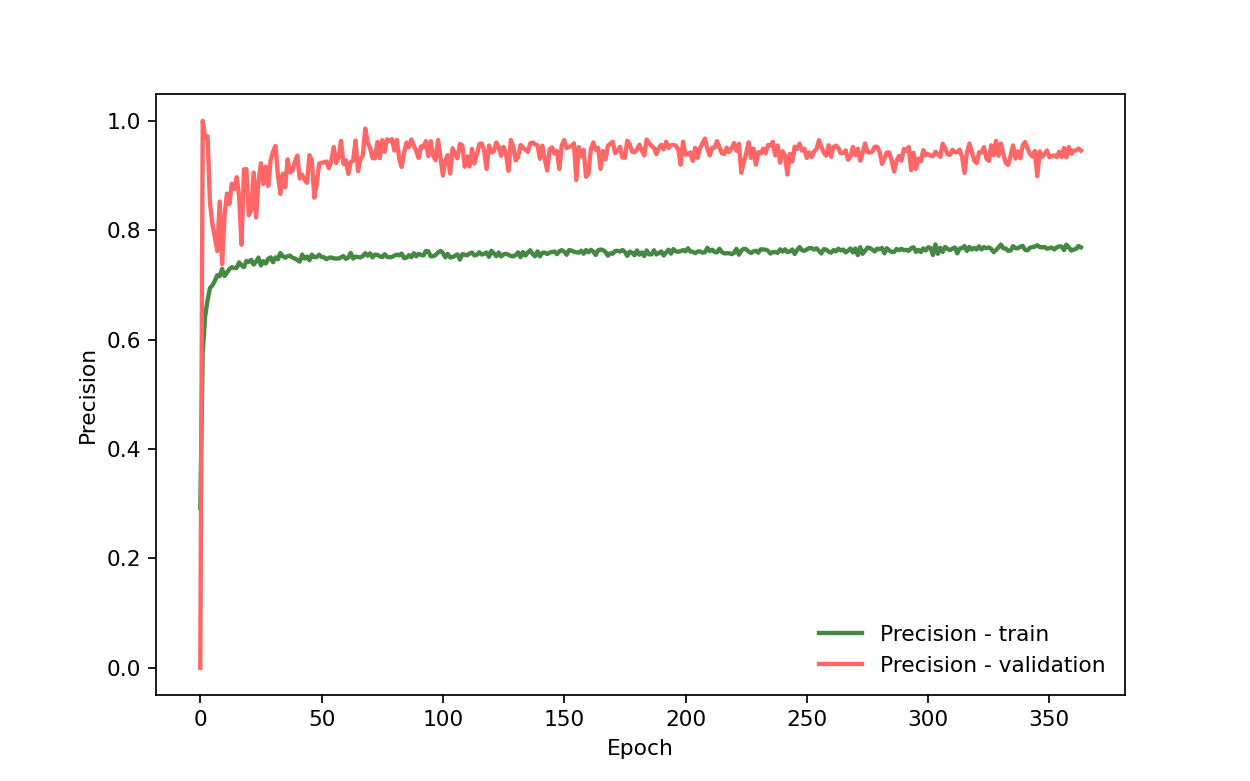

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth']=2
fig,ax = plt.subplots(figsize=(8,5))
ax.plot( history.history['precision'], c='#448844', label='Precision - train')
ax.plot( history.history['val_precision'], c='#ff6666', label='Precision - validation')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(frameon=False)



<IPython.core.display.Javascript object>


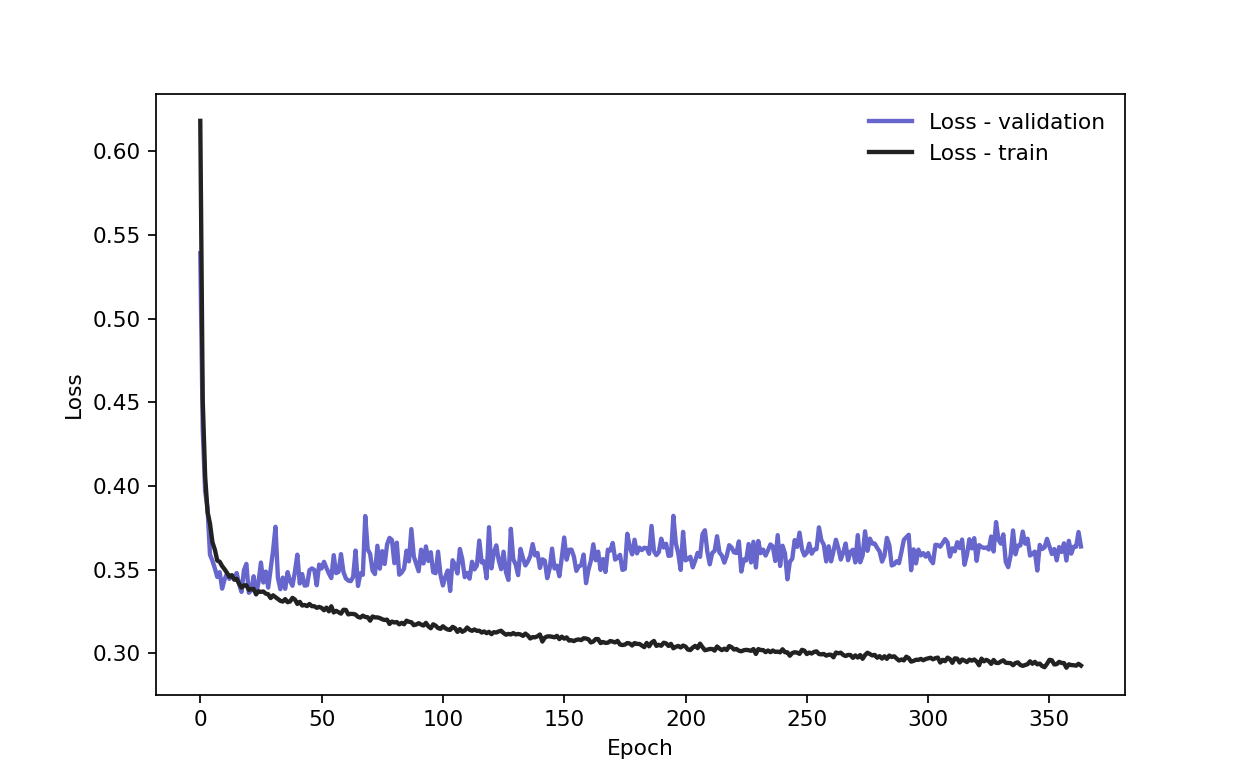

In [9]:

fig,ax = plt.subplots(figsize=(8,5))
ax.plot( history.history['val_loss'], c='#6666cc', label='Loss - validation')
ax.plot( history.history['loss'], c='#222222', label='Loss - train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False)


<IPython.core.display.Javascript object>


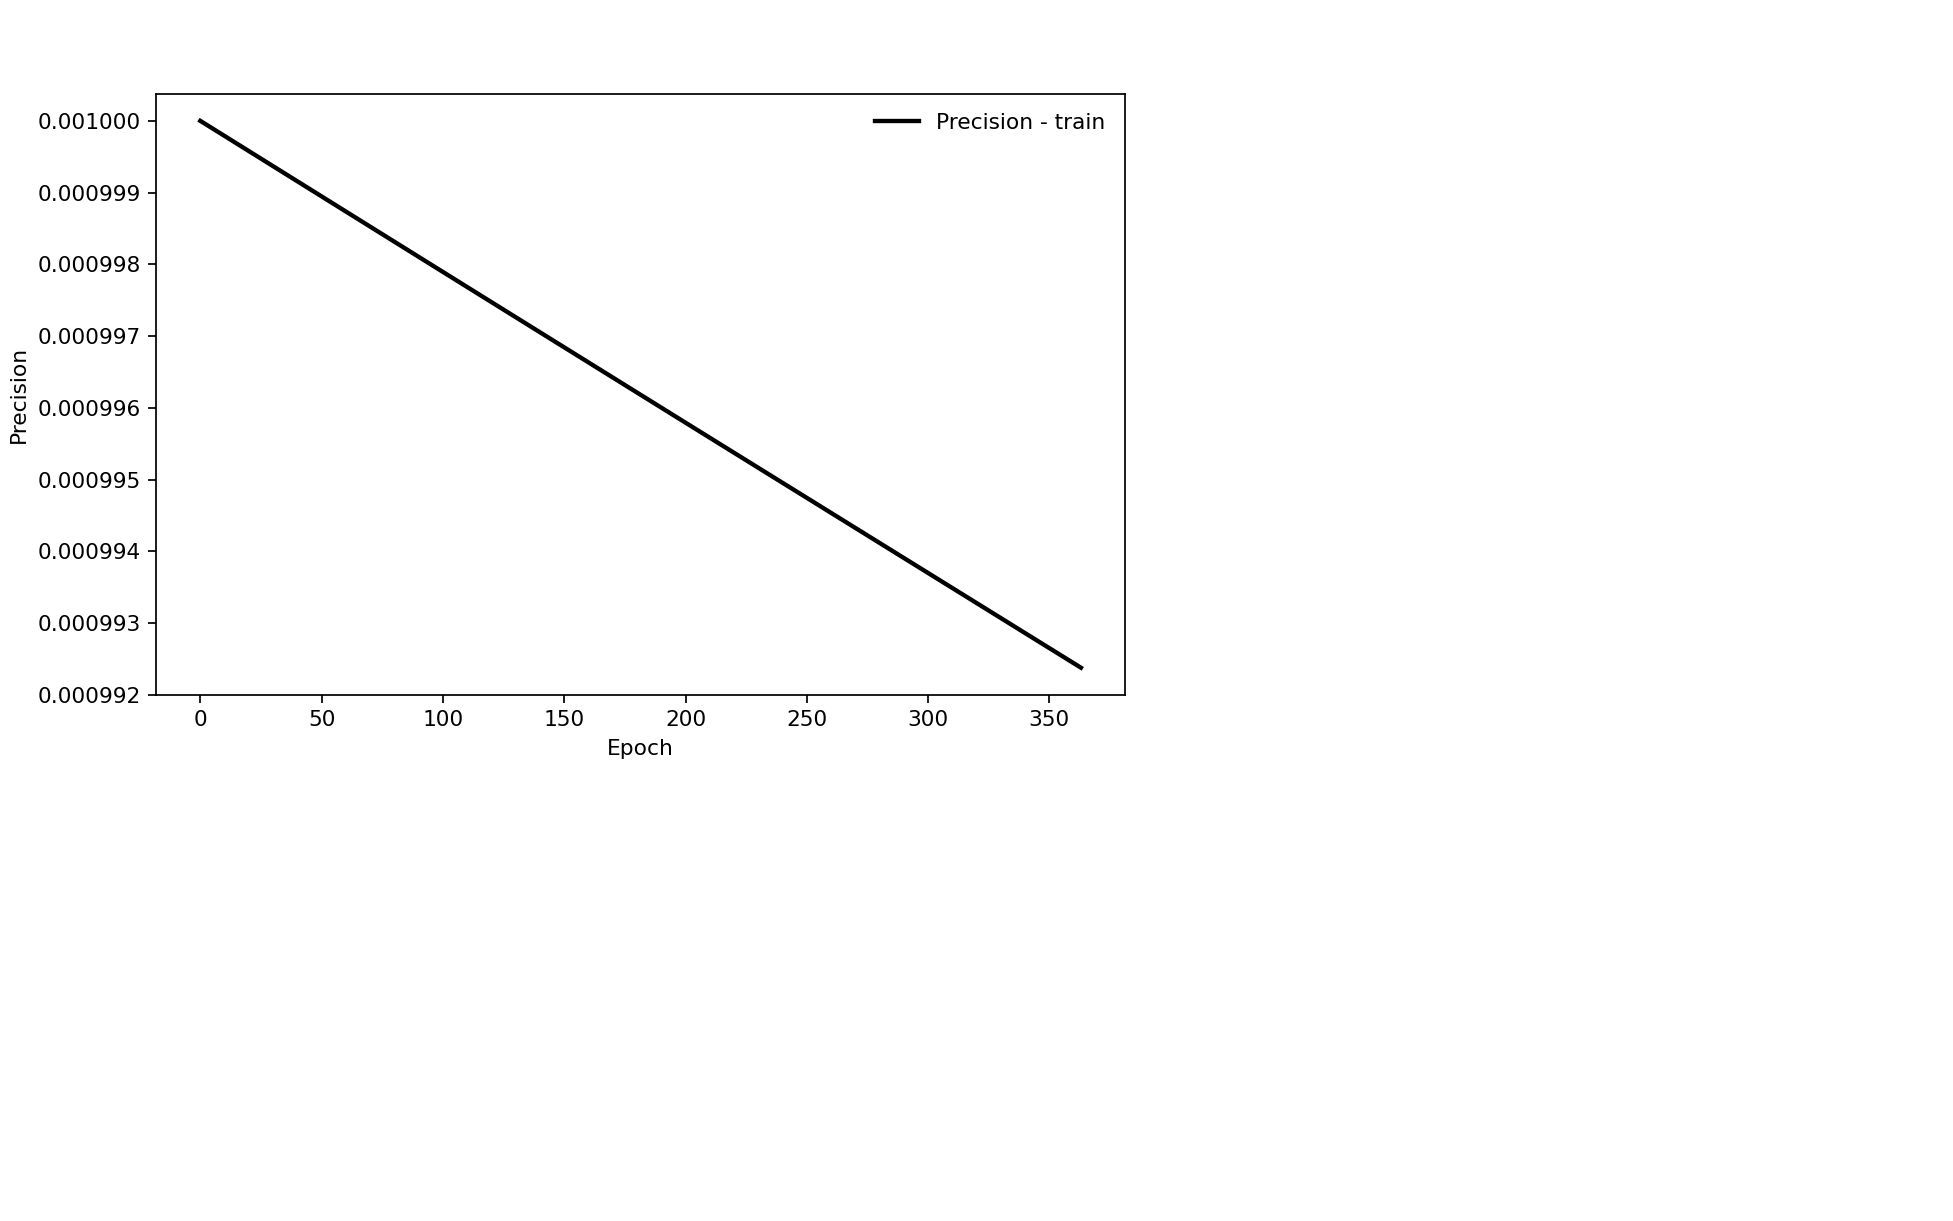

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth']=2
fig,ax = plt.subplots(figsize=(8,5))
ax.plot( history.history['lr'], c='#000000', label='Precision - train')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(frameon=False)



Best precisions and configs
- (0.9588477366255144,
 {'initial_learning_rate': 0.001,
  'decay_steps': 5000,
  'decay_rate': 0.9,
  'staircase': False,
  'name': None})
-  (0.9617021276595744,
 {'initial_learning_rate': 0.01,
  'decay_steps': 5000,
  'decay_rate': 0.9,
  'staircase': False,
  'name': None})
-Precision: 0.9617021276595744, accuracy: 0.8161999291031549, model: None, lr: {'initial_learning_rate': 0.01, 'decay_steps': 5000, 'decay_rate': 0.9, 'staircase': False, 'name': None}  
-Precision: 0.8822463768115942, accuracy: 0.8525345622119815,  lr: {'initial_learning_rate': 0.0001, 'decay_steps': 5000, 'decay_rate': 0.95, 'staircase': False, 'name': None}
1
-Precision: 0.8867562380038387, accuracy: 0.8491669620701878,  lr: {'initial_learning_rate': 0.0001, 'decay_steps': 5000, 'decay_rate': 0.9, 'staircase': False, 'name': None}
